In [1]:
## Install PyTorch Geometric for Torch 1.10 and CUDA 11.1 backend
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 482 kB 2.4 MB/s            
     |████████████████████████████████| 41 kB 1.4 MB/s             


In [3]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## Class & Function Definitions

In [4]:
### A simple Message-Passing network w/ common aggregation schemes.
class Simple_GNN(torch.nn.Module):

    def __init__(self,in_features,int_features,out_features,depth,aggregation_mode = 'mean',dropout_prob = .1):
        '''
        [in_features]       - # of input features.
        [int_features]      - # of features in message-passing layers. Within the 
                              GNN literature, this is typically a constant.
        [out_features]      - # of output features. Corresponds to # of classes,
                              regression targets, etc.
        [depth]             - # of message-passing layers. 
        [aggregation_mode]  - choice of aggregation scheme. Can be 'mean',
                              'sum', 'max', or 'none'
        [dropout_prob]      - probability used for Dropout (see Srivastava et al., 2017)
        '''

        super(Simple_GNN,self).__init__()
        assert aggregation_mode in ['mean','sum','max','none']

        self.f_in = torch.nn.Linear(in_features,int_features)
        self.f_int = torch.nn.ModuleList([torch.nn.Sequential(*[torch.nn.Linear(int_features,int_features),
                                                                torch.nn.LeakyReLU(),
                                                                torch.nn.Dropout(dropout_prob)])
                                              for _ in range(depth)])
        self.f_out = torch.nn.Linear(int_features,out_features)

        if aggregation_mode == 'mean': self.agg = torch_scatter.scatter_mean
        elif aggregation_mode == 'sum': self.agg = torch_scatter.scatter_sum
        elif aggregation_mode == 'max': self.agg = torch_scatter.scatter_max

        self.aggregation_mode = aggregation_mode

    def forward(self,node_features,edge_index,edge_weights = None):
        '''
        [node_features]  - Matrix of node features. First (batch) dimension corresponds
                           to nodes; second to features.
        [edge_index]     - Edge list representation of a graph. Shape [num_edges]x2
        [edge_weights]   - Optional scalar edge weights. Shape [num_edges,1]
        '''

        node_features = self.f_in(node_features)
        for idx,layer in enumerate(self.f_int):
            if self.aggregation_mode is not 'none':
                if edge_weights is not None:
                    aggregated_node_features = self.agg(edge_weights * node_features[edge_index[:,0]],
                                                                    edge_index[:,1],dim=0)
                else:
                    aggregated_node_features = self.agg(node_features[edge_index[:,0]],edge_index[:,1],dim=0) 
            else:
                aggregated_node_features = node_features
                
            if isinstance(aggregated_node_features,tuple): 
                aggregated_node_features = aggregated_node_features[0]

            node_features = node_features + layer(aggregated_node_features)
        return self.f_out(node_features),node_features

<>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-4-a647872a82ef>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.aggregation_mode is not 'none':


In [5]:
### General purpose object for storing graph data
class Graph(object):
    def __init__(self,edge_index = None,edge_metadata = None,node_metadata = None):
        self.edge_index = edge_index
        self.edge_metadata = edge_metadata
        self.node_metadata = node_metadata
        if node_metadata is not None: 
            self.num_nodes = node_metadata.shape[0]

    def read_edges(self,filepath):
        ''' Edges should be stored as follows:
            0 1 3.1 2.0
            0 2 1.0 0.0
            1 0 3.1 2.0
            ...
        where the first two columns are node indices and the remainder
        are edge features. '''

        with open(filepath,'r') as f:
          edges = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
        if edges.shape[1] == 2:
          self.edge_index = edges.long()
        elif edges.shape[1] >= 3:
          self.edge_index = edges[:,:2].long()
          self.edge_metadata = edges[:,2::]
          
    def read_node_metadata(self,filepath,padding_value = 0.0):
        ''' Nodes should be stored as follows:
            0 4.1 9.2 1.1 ...
            2 3.3 1.1 9.0 ...
            ...
        where the first column is the node index and the remainder
        are node features. If a node is not listed but should still 
        clearly exist (e.g, nodes '0' and '2' are present in the file
        but not node '1'), the missing node is given constant features 
        set to [padding_value]'''

        with open(filepath,'r') as f:
          nodes = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
          
        self.num_nodes = 1 + nodes[:,0].max().long()
        node_metadata = padding_value * torch.ones((self.num_nodes,nodes.shape[1]-1))
        node_metadata[nodes[:,0].long()] = nodes[:,1::]   #GE

        self.node_metadata = node_metadata

In [6]:
### Dataset consisting of multiple _Graph_ objects
class GraphsDataset(object):
    ''' Graph metadata is expected to be saved 
        under [graph_dir]/[...]/edges.txt and
        [graph_dir]/[...]/nodes.txt.
    ******* Optional Arguments *********
    [add_self_loops] - Add self loop to each graph. 
                       This tends to improve importance,
                       and it resolves issues with 
                       disconnected nodes.
    '''
    def __init__(self,graph_dir,add_self_loops = True):
        self.root = graph_dir
        self.graphs = os.listdir(graph_dir)
        self.add_self_loops = add_self_loops
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self,idx):
        G = Graph()
        G.read_edges(self.root + '/' + self.graphs[idx]+'/edges.txt')
        G.read_node_metadata(self.root + '/' + self.graphs[idx]+'/nodes.txt')

        if self.add_self_loops:
            self_loops = torch.cat((torch.arange(G.num_nodes)[:,None],torch.arange(G.num_nodes)[:,None]),dim=-1)
            G.edge_index = torch.cat((G.edge_index,self_loops),dim=0)
            G.edge_metadata = torch.cat((G.edge_metadata,torch.ones((G.num_nodes,1))),dim=0)
        return G 

### Helper function to construct batches of graphs. We assume the user wants to
### perform graph-level tasks, and so our target variable is chosen as
### G.node_metadata[0,0] i.e, the first feature of the first node.
def collate_fn(data):
    c,n = 0,0
    for idx,G in enumerate(data):
        if idx == 0: 
            X,Y = G.node_metadata[:,1::],G.node_metadata[0,0][None]
            edge_index,edge_weights = G.edge_index,G.edge_metadata
            batch_index = c * torch.ones(G.num_nodes)
        else:
            X = torch.cat((X,G.node_metadata[:,1::]),dim=0)
            Y = torch.cat((Y,G.node_metadata[0,0][None]),dim=0)

            edge_index = torch.cat((edge_index,n + G.edge_index),dim=0)
            edge_weights = torch.cat((edge_weights,G.edge_metadata),dim=0)
            batch_index = torch.cat((batch_index,c * torch.ones(G.num_nodes)),dim=0)
        n += G.num_nodes
        c += 1

    return {'X':X,'edge_index':edge_index,'edge_weights':edge_weights,'Y':Y.long(),'batch_index':batch_index.long()}

In [23]:
### Call to fit node-level model and save results
class GNN_Node_Trainer(object):
    def __init__(self,graph,**kwargs):
        '''
        [graph]  - Instance of _Graph_. Expects to be fully initialized. 
        ******* Optional Arguments *********
        [train_index],[test_index] - Partitions graph into train and test sets.
                                     Defaults to random 60%/40% split.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy.
        [random_seed]              - Defaults to 0. 
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graph,Graph)        
        self.graph = graph

        ### If train_index and test_index are not provided, we randomly
        ### select a train/test split.
        r = torch.randperm(graph.num_nodes)
        self.train_index,self.test_index = kwargs.get('train_index',r[:int(.6 * len(r))]),\
                                  kwargs.get('test_index',r[int(.6 * len(r))::])

        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume the first column of 'self.graph.node_metedata' to be our 
        target values.
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)

        ### Load data to device.
        node_features,edge_index,edge_weights = self.graph.node_metadata.to(device),\
                                                    self.graph.edge_index.to(device),\
                                                    self.graph.edge_metadata.to(device)
        X,Y = node_features[:,1::].to(device),node_features[:,0].to(device)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        for idx in pbar:
            ### Get predictions and compute losses over train and test sets.
            predictions,_ = model(X,edge_index,edge_weights)
            train_loss,test_loss = self.loss_func(predictions[self.train_index],Y[self.train_index],
                                                  edge_index,edge_weights),\
                                          self.loss_func(predictions[self.test_index],Y[self.test_index],
                                                  edge_index,edge_weights)

            pbar.set_description(f'Train Loss: {train_loss.item():.3f}\tTest Loss: {test_loss.item():.3f}')
            if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

            ### Backpropagate w.r.t training loss
            train_loss.backward()
            opt.step()
            opt.zero_grad()

            ### Save losses and compute additional metrics
            metrics['train_loss'].append(train_loss.item())
            metrics['test_loss'].append(test_loss.item())
            for key in metrics_callback.keys():
                metrics['train_'+key].append(metrics_callback[key](predictions[self.train_index],Y[self.train_index],
                                                        edge_index,edge_weights))
                metrics['test_'+key].append(metrics_callback[key](predictions[self.test_index],Y[self.test_index],
                                                        edge_index,edge_weights))

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))
        # print("metrics: ", metrics)

        return predictions

In [24]:
### Call to fit graph-level model and save results
class GNN_Graph_Trainer(object):
    def __init__(self,graphs,collate_fn,**kwargs):
        '''
        [graphs]      - Instance of _GraphsDataset_. Expects to be fully initialized. 
        [collate_fn]  - Collate function for batching purposes.
        ******* Optional Arguments *********
        [batch_size]               - Number of graphs per train/val batch. Defaults
                                     to 50.
        [train_%]                  - Pct. split into train set. Defaults to 80%/20%.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy. 
        [random_seed]              - Defaults to 0.
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graphs,GraphsDataset)
        self.graphs = graphs
        self.collate_fn = collate_fn

        self.train_pct = kwargs.get('train_%',.8)

        self.batch_size = kwargs.get('batch_size',50)
        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume 'self.graphs[idx].node_metedata[0,0]' 
        to be our target value for all idx \in [0,len(self.graphs)] .
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)
        
        ### Generate train/test split.
        train,test = torch.utils.data.random_split(self.graphs,[int(len(self.graphs) * self.train_pct),
                                                               len(self.graphs) - int(len(self.graphs) * self.train_pct)]
                                                  )
        train_loader,test_loader = torch.utils.data.DataLoader(train,batch_size=self.batch_size,shuffle=True,collate_fn=self.collate_fn),\
                              torch.utils.data.DataLoader(test,batch_size=self.batch_size,shuffle=True,collate_fn=self.collate_fn)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        for idx in pbar:

            ### Training loop
            model.train()
            for data in train_loader:
                X,Y,edge_index,edge_weights,batch_index = data['X'].to(device),data['Y'].to(device),data['edge_index'].to(device),\
                                                              data['edge_weights'].to(device),data['batch_index'].to(device)

                predictions,_ = model(X,edge_index,edge_weights)
                ### To keep things simple, we employ mean READOUT to produce a global
                ### graph embedding. 
                train_loss = self.loss_func(torch_scatter.scatter_mean(predictions,batch_index,dim=0),Y,edge_index,edge_weights)

                pbar.set_description(f'Train Loss: {train_loss.item():.3f}')
                if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

                train_loss.backward()
                opt.step()
                opt.zero_grad()

                ### Compute and save metrics.
                metrics['train_loss'].append(train_loss.item())
                for key in metrics_callback.keys():
                        metrics['train_'+key].append(metrics_callback[key](torch_scatter.scatter_mean(predictions,batch_index,dim=0),
                                                                    Y,edge_index,edge_weights))
                        
            ### Evaluation loop. 
            model.eval()
            with torch.no_grad():
                for data in test_loader:
                    X,Y,edge_index,edge_weights,batch_index = data['X'].to(device),data['Y'].to(device),data['edge_index'].to(device),\
                                                              data['edge_weights'].to(device),data['batch_index'].to(device)

                    predictions,_ = model(X,edge_index,edge_weights)
                    train_loss = self.loss_func(torch_scatter.scatter_mean(predictions,batch_index,dim=0),Y,edge_index,edge_weights)

                    pbar.set_description(f'Test Loss: {train_loss.item():.3f}')

                    metrics['test_loss'].append(train_loss.item())
                    for key in metrics_callback.keys():
                          metrics['test_'+key].append(metrics_callback[key](torch_scatter.scatter_mean(predictions,batch_index,dim=0),
                                                                    Y,edge_index,edge_weights))

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))
        # print("metrics: ", metrics)

        return predictions

## Node Classification Example

In [25]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

import networkx as nx
G = nx.karate_club_graph()

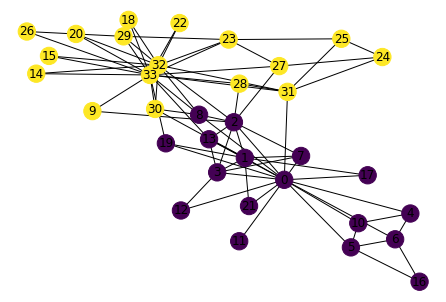

In [26]:
### Plot the network. We see it consists of a total of 34 nodes (numbered below 
### 0-33). Colors indicate class membership.
labels = [0 if G.nodes[idx]['club'] == 'Mr. Hi' else 1 for idx in range(len(G.nodes))]
pos = nx.drawing.layout.spring_layout(G)
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=labels) 

In [27]:
### Write edge list to file.
torch.manual_seed(0)
with open('edges.txt','w') as f:
  for edge in list(G.edges):
    f.write(f'{edge[0]} {edge[1]} {1.0}\n')

### Write node metadata to file. Nodes belonging to class '0' have features
### drawn from N(1,1). Nodes belonging to class '1' have features drawn from 
### the standard normal. 
with open('nodes.txt','w') as f:
  for node in list(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          X_str = ' '.join([str(element.item()) for element in .5 + torch.randn((16))])
          f.write(f'{node} {0} ' + X_str + ' \n')
      elif G.nodes[node]['club'] == 'Officer':
          X_str = ' '.join([str(element.item()) for element in torch.randn((16))])
          f.write(f'{node} {1} ' + X_str + ' \n')

### Read files into _Graph_ object.
karate_club_graph = Graph()
karate_club_graph.read_edges('edges.txt')
karate_club_graph.read_node_metadata('nodes.txt')

In [28]:
### Alternatively, we can read the data into a _Graph_ directly.

torch.manual_seed(0)
for idx,node in enumerate(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          nX = torch.cat((torch.zeros((1)).long(),.5 + torch.randn((16))),dim=0)
      elif G.nodes[node]['club'] == 'Officer':
          nX = torch.cat((torch.ones((1)).long(),torch.randn((16))),dim=0)

      if idx == 0: X = nX[None]
      else: X = torch.cat((X,nX[None]))

karate_club_graph = Graph(torch.Tensor(np.array(G.edges)).long(),torch.ones((len(G.edges),1)),X)

In [29]:
### We create a Simple_GNN w/ 16 input features, 
### 64 intermediate features, and an output dimension
### of 2 (as this is a binary classification problem).
model = Simple_GNN(16,64,2,3,aggregation_mode='mean')

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(karate_club_graph,num_epochs=200,random_seed=1)
predictions = trainer(model)

Train Loss: 0.011	Test Loss: 0.394: 100%|██████████| 200/200 [00:00<00:00, 397.05it/s]

metrics:  {'train_loss': [0.7515160441398621, 0.6562477946281433, 0.6054595708847046, 0.5636740326881409, 0.5198489427566528, 0.4833052158355713, 0.4572006165981293, 0.42603880167007446, 0.41080617904663086, 0.3797367513179779, 0.3626638650894165, 0.3377731442451477, 0.32389310002326965, 0.3048384487628937, 0.29365959763526917, 0.2811379134654999, 0.26962417364120483, 0.24919632077217102, 0.2410593032836914, 0.23167173564434052, 0.22565674781799316, 0.21319416165351868, 0.20855538547039032, 0.1991017460823059, 0.18557052314281464, 0.18056726455688477, 0.17372196912765503, 0.16478067636489868, 0.15929748117923737, 0.15106157958507538, 0.14437803626060486, 0.13814492523670197, 0.1323331892490387, 0.1264658272266388, 0.12487626075744629, 0.11762242019176483, 0.11444091796875, 0.10778150707483292, 0.1028042882680893, 0.0941302478313446, 0.09736546874046326, 0.09130741655826569, 0.08625447750091553, 0.08219844102859497, 0.07730051875114441, 0.07784445583820343, 0.07525107264518738, 0.071369

In [30]:
print(f"Train Class #: {karate_club_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
print(f"Test Class #: {karate_club_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")

Train Class #: tensor([10, 10])
Test Class #: tensor([7, 7])


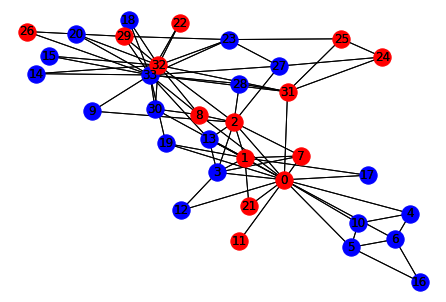

In [31]:
### Plot training (blue) and test (red) sets
nx.drawing.draw(G,pos=pos,node_color='blue',nodelist=trainer.train_index.tolist(),with_labels=True)
nx.drawing.draw(G,pos=pos,node_color='red',nodelist=trainer.test_index.tolist(),with_labels=True)

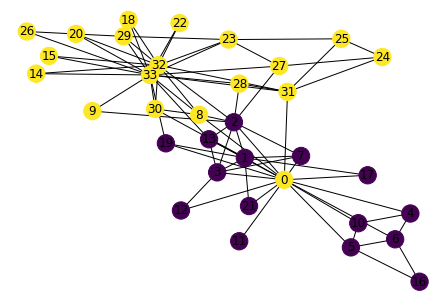

In [32]:
### Plot predictions of our GNN
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=predictions.argmax(dim=1))

In [33]:
### For the sake of comparison, let's remove the aggreation step
### from our GNN (essentially creating an MLP) and see how well
### it now performs. 
model = Simple_GNN(16,64,2,3,aggregation_mode='none')
mlp_predictions = trainer(model)

Train Loss: 0.006	Test Loss: 2.147: 100%|██████████| 200/200 [00:00<00:00, 529.80it/s]


metrics:  {'train_loss': [0.8320885896682739, 0.7012350559234619, 0.6575992107391357, 0.5872213244438171, 0.5691641569137573, 0.52619868516922, 0.4707704484462738, 0.43812817335128784, 0.42270374298095703, 0.3928465247154236, 0.3478052020072937, 0.34424328804016113, 0.3320074677467346, 0.2897226810455322, 0.27949491143226624, 0.24199381470680237, 0.22394144535064697, 0.22626729309558868, 0.19473128020763397, 0.1817690134048462, 0.16153380274772644, 0.16281399130821228, 0.13499002158641815, 0.13525784015655518, 0.12683460116386414, 0.11406505107879639, 0.09842921793460846, 0.09659957885742188, 0.07867730408906937, 0.07403551042079926, 0.06659930944442749, 0.060065459460020065, 0.052881546318531036, 0.05735432356595993, 0.05616758018732071, 0.04328066483139992, 0.038771726191043854, 0.03473860025405884, 0.03680289536714554, 0.02885369397699833, 0.023996755480766296, 0.02844441868364811, 0.02308667078614235, 0.021832721307873726, 0.02213861420750618, 0.017546329647302628, 0.02320453897118

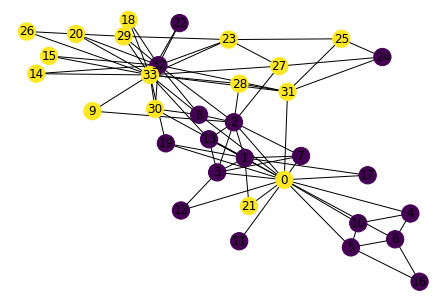

In [34]:
### Plot the MLP predictions. 
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=mlp_predictions.argmax(dim=1))

## Graph Classification Example

In [ ]:
### Dwivedi et al. (2020) proposed an MNIST benchmark for graph classification. Each node
### corresponds to a superpixel determined via the SLIC method (Achanta et al., 2011).
### Node features consist of intensities and positions in R2. Edges are
### determined using k-nearest neighboors, and the edge weights are from an RBF kernel.
MNIST_Dataset = torch_geometric.datasets.GNNBenchmarkDataset('.','MNIST',split='train')
os.makedirs('MNIST_Superpixels',exist_ok=True)
print("Nb samples: ", len(MNIST_Dataset))
for idx,G in enumerate(MNIST_Dataset):
  if (idx % 1000 == 0): print(f"{idx} / 55000")
  os.makedirs(f'MNIST_Superpixels/{idx}',exist_ok=True)
  nodes = torch.cat((torch.arange(G.x.shape[0])[:,None],torch.cat((G.y[None].repeat(G.x.shape[0],1),torch.cat((G.x,G.pos),dim=1)),dim=1)),dim=1)
  pd.DataFrame(nodes.numpy()).to_csv(f'MNIST_Superpixels/{idx}/nodes.txt',header=False,index=False,sep=' ')

  edges = torch.cat((G.edge_index.permute(1,0),G.edge_attr[:,None]),dim=1)
  pd.DataFrame(edges.numpy()).to_csv(f'MNIST_Superpixels/{idx}/edges.txt',header=False,index=False,sep=' ')

Extracting ./MNIST/raw/MNIST_v2.zip
Processing...
Done!


Nb samples:  55000
0 / 55000
1000 / 55000
2000 / 55000
3000 / 55000
4000 / 55000
5000 / 55000
6000 / 55000
7000 / 55000
8000 / 55000
9000 / 55000
10000 / 55000
11000 / 55000
12000 / 55000
13000 / 55000
14000 / 55000
15000 / 55000
16000 / 55000
17000 / 55000
18000 / 55000
19000 / 55000
20000 / 55000
21000 / 55000
22000 / 55000
23000 / 55000
24000 / 55000
25000 / 55000
26000 / 55000
27000 / 55000
28000 / 55000
29000 / 55000
30000 / 55000
31000 / 55000
32000 / 55000
33000 / 55000
34000 / 55000
35000 / 55000
36000 / 55000
37000 / 55000
38000 / 55000
39000 / 55000
40000 / 55000
41000 / 55000
42000 / 55000
43000 / 55000
44000 / 55000
45000 / 55000
46000 / 55000
47000 / 55000
48000 / 55000
49000 / 55000
50000 / 55000
51000 / 55000
52000 / 55000
53000 / 55000
54000 / 55000


In [ ]:
### Instantiate _GraphsDataset_ using the MNIST data.
MNIST_Graphs = GraphsDataset('MNIST_Superpixels')

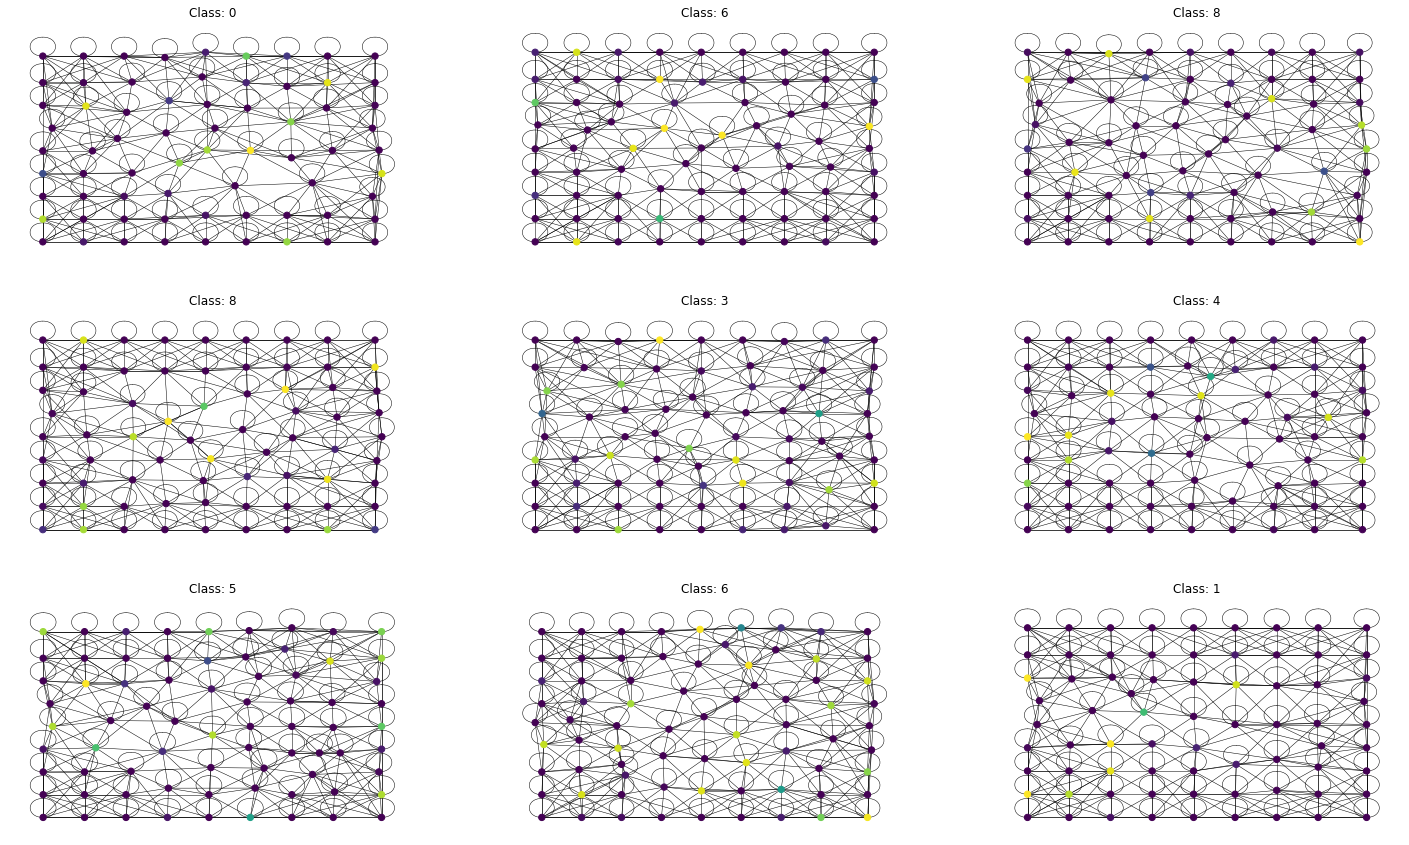

In [ ]:
### Plot a subset of the data. Note that superpixels can be of varying size and 
### shape, so the following networks are diffult to interpret visually.
plt.figure(figsize=(25,15))

for idx in range(9):
  plt.subplot(3,3,3 * ((idx+1)//3) + ((idx+1) - 3 * ((idx+1)//3)))
  class_idx = MNIST_Graphs[idx].node_metadata[0,0].long()

  G = nx.Graph()
  G.add_edges_from(MNIST_Graphs[idx].edge_index.numpy())

  nx.drawing.draw(G,node_size=40,width=.5,pos=MNIST_Graphs[idx].node_metadata[:,2::].numpy(),node_color=MNIST_Graphs[idx].node_metadata[:,1].numpy())
  plt.title(f'Class: {class_idx}')

In [ ]:
### ### We initialize a Simple_GNN w/ 3 input features, 
### 128 intermediate features, and an output dimension
### of 10.
trainer = GNN_Graph_Trainer(MNIST_Graphs,collate_fn,num_epochs = 10)
model = Simple_GNN(3,128,10,10,aggregation_mode='sum')

### In addition to the losses, we wish to record the accuracy
### of our model throughout training. 
predictions = trainer(model, metrics_callback={'accuracy':
                         lambda x,y,E,W:(x.argmax(dim=-1) == y).float().mean().item()},
                    device='cuda:0')

Test Loss: 0.597: 100%|██████████| 10/10 [24:20<00:00, 146.03s/it]


In [ ]:
metrics = torch.load('gnn_results/run_0/metrics')

In [ ]:
### Plot the training and test losses.
train_losses = torch.Tensor(metrics['train_loss']).view(-1,44000//50)
test_losses = torch.Tensor(metrics['test_loss']).view(-1,11000//50)

plt.errorbar(torch.arange(train_losses.shape[0]),train_losses.mean(1),
             yerr=train_losses.std(1),label='Training')
plt.errorbar(torch.arange(test_losses.shape[0]),test_losses.mean(1),
             yerr=test_losses.std(1),label='Test')
plt.legend(title='Losses')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epoch')
plt.yscale('log')

RuntimeError: ignored

Text(0.5, 0, 'Epoch')

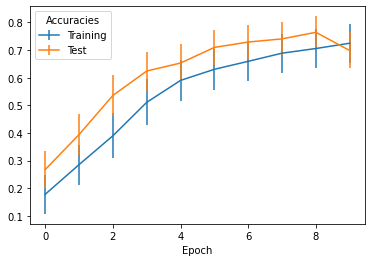

In [ ]:
### Plot the training and test accuracies.
train_acc = torch.Tensor(metrics['train_accuracy']).view(-1,44000//50)
test_acc = torch.Tensor(metrics['test_accuracy']).view(-1,11000//50)

plt.errorbar(torch.arange(train_acc.shape[0]),100*train_acc.mean(1),
             yerr=100*train_acc.std(1),label='Training')
plt.errorbar(torch.arange(test_acc.shape[0]),100*test_acc.mean(1),
             yerr=100*test_acc.std(1),label='Test')
plt.legend(title='Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

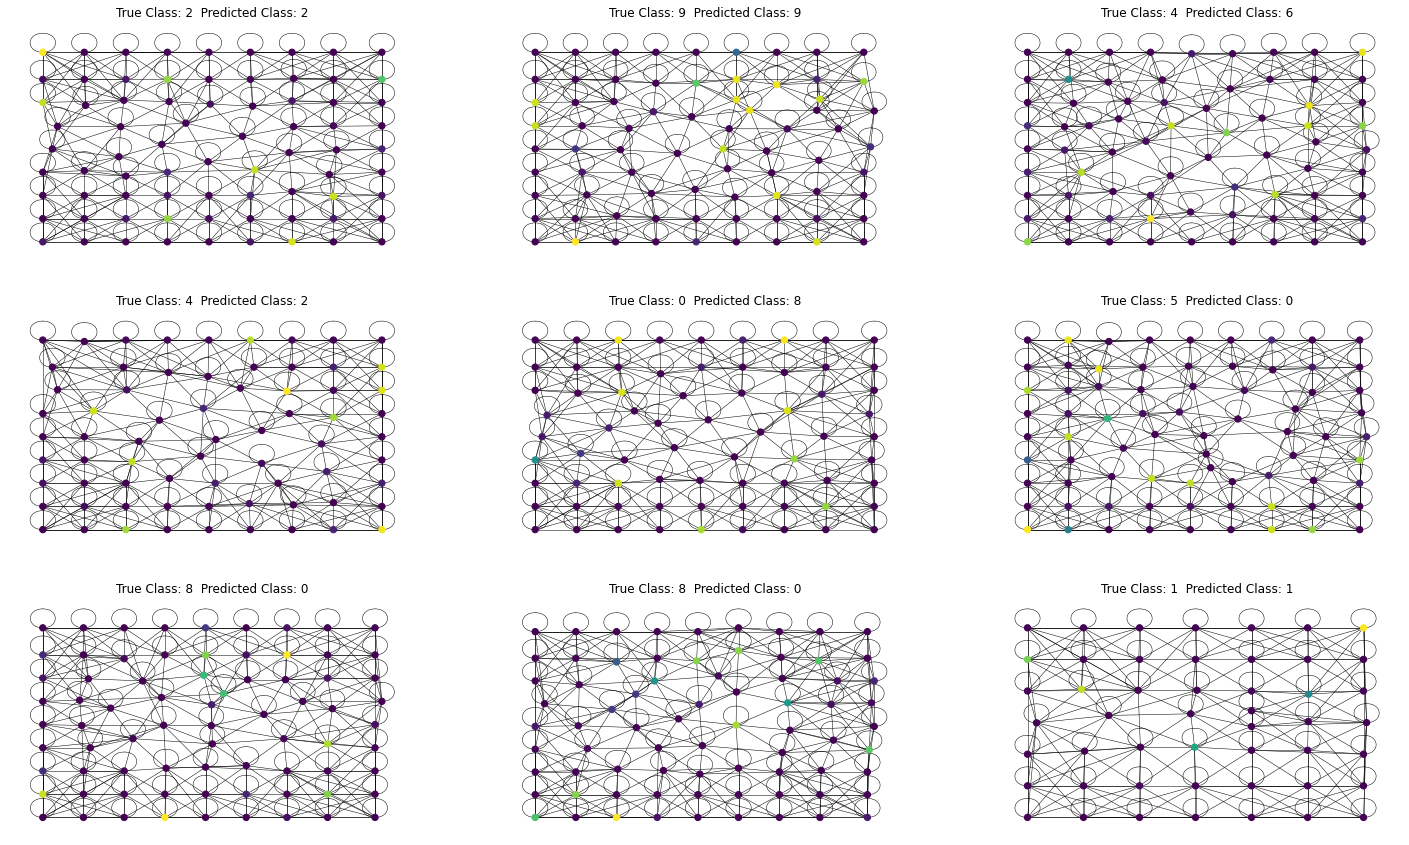

In [ ]:
### Plot predictions. Our model is quite simplistic, and so its
### performance leaves something to be desired. Some potential improvements are
### 1) updating the aggregation function to be anisotrophic and 
### 2) replacing the mean READOUT operation with a trainable global pooling
### layer.
plt.figure(figsize=(25,15))

for idx in range(9):
  plt.subplot(3,3,3 * ((idx+1)//3) + ((idx+1) - 3 * ((idx+1)//3)))
  class_idx = MNIST_Graphs[idx].node_metadata[0,0].long()

  G = nx.Graph()
  G.add_edges_from(MNIST_Graphs[idx].edge_index.numpy())

  X = MNIST_Graphs[idx].node_metadata[:,1::]
  edge_index,edge_weights = MNIST_Graphs[idx].edge_index,\
                              MNIST_Graphs[idx].edge_metadata

  predictions,_ = model(X.to('cuda:0'),edge_index.to('cuda:0'),edge_weights.to('cuda:0'))
  predictions = predictions.mean(dim=0).detach().cpu()

  nx.drawing.draw(G,node_size=40,width=.5,pos=MNIST_Graphs[idx].node_metadata[:,2::].numpy(),node_color=MNIST_Graphs[idx].node_metadata[:,1].numpy())
  plt.title(f'True Class: {class_idx}  Predicted Class: {torch.argmax(predictions)}')